# <tt>RedNoiseFALs</tt> software package

<tt>RedNoiseFALs</tt> package calculates the false alarm levels for the LombScargle periodogram based on two red noise models;
1. Autoregressive model of order 1 - AR(1)
2. Power law

The package first fits the red noise models directly to the LombScargle periodogram, chooses the best-fit noise model to the data and then calculates the red-noise-based FALs based on that model. The details of the method and functionalities of the <tt>RedNoiseFALs</tt> class are demonstrated in this notebook.

### Set up <tt>python</tt> environment

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import astropy
from astropy.timeseries import LombScargle
import scipy.optimize as sopt
from scipy.optimize import minimize

# Load our software package
import sys
sys.path.append('..')
from RedNoiseFALs import RedNoiseFALs

plt.rcParams.update({"font.size":16, "axes.labelsize":16, "font.family":"sans-serif", "font.sans-serif":"Arial"})

### Read the dataset using pandas


This is the <a href="https://ui.adsabs.harvard.edu/abs/2012Natur.491..207D/abstract">Dumusque et al. (2012)</a> HARPS dataset of the famous star $\alpha$ Centauri B.

In [2]:
data = pd.read_csv('Dumusque2012_aCenB.txt',sep ="\t",skiprows=[1])
data

,jdb,RV,RV error,realistic RV error,Bisector,FWHM,Photon noise,log(R'hk),log(R'hk) error,Low pass filter,log(R'hk).1,Alpha (hours),Delta (degrees),Seeing
0,54524.907275,-22.314921,0.000546,0.001070,0.002387,6.255717,0.000071,-4.9920,0.0005,-4.9929,14.658885,-60.834472,0.84,NaN
1,54525.883318,-22.315721,0.000481,0.001038,0.002536,6.256078,0.000049,-4.9918,0.0003,-4.9930,14.658884,-60.834473,0.76,NaN
2,54526.883034,-22.314824,0.000471,0.001034,0.001458,6.253960,0.000050,-4.9935,0.0003,-4.9931,14.658884,-60.834474,0.65,NaN
3,54527.890455,-22.316663,0.000471,0.001034,0.002094,6.255564,0.000048,-4.9951,0.0003,-4.9932,14.658883,-60.834475,0.80,NaN
4,54528.875046,-22.316174,0.000493,0.001044,0.001881,6.256754,0.000061,-4.9958,0.0004,-4.9933,14.658883,-60.834476,0.81,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
454,55727.465914,-22.939498,0.000363,0.000989,0.005321,6.291550,0.000038,-4.8966,0.0002,-4.8969,14.658448,-60.833371,1.08,NaN
455,55727.498923,-22.940675,0.000367,0.000990,0.005335,6.291034,0.000038,-4.8981,0.0002,-4.8969,14.658448,-60.833371,1.08,NaN
456,55728.472526,-22.939715,0.000367,0.000990,0.006016,6.293730,0.000049,-4.8962,0.0003,-4.8966,14.658447,-60.833367,1.19,NaN
457,55728.528181,-22.940041,0.000367,0.000990,0.005932,6.292235,0.000053,-4.8963,0.0003,-4.8966,14.658447,-60.833367,1.10,NaN


The activity indicator $\log (R^{\prime}_{HK})$ timeseries is employed for this demo. These calculations are featured in Section 4.1 of our paper.

In [3]:
time = np.array(data['jdb'])
obs = np.array(data['log(R\'hk)'])
eobs = np.array(data['log(R\'hk) error'])

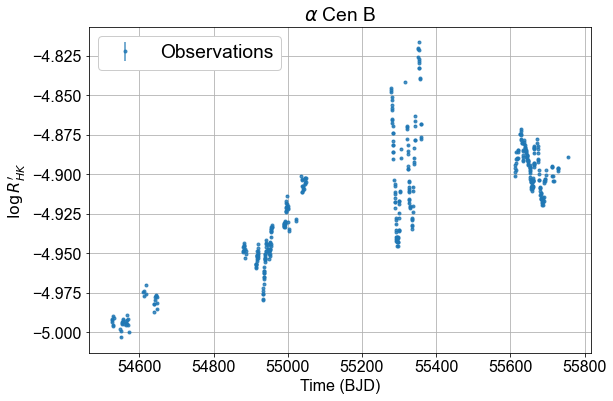

In [4]:
plt.figure(figsize=(9,6))
plt.title(r"$\alpha$ Cen B")
plt.errorbar(time, obs, yerr=eobs, fmt='.', ls=None, alpha=0.8,label= "Observations")
plt.xlabel("Time (BJD)")
plt.ylabel(r'$\log R^{\prime}_{HK}$')
plt.tick_params(axis='y')
plt.grid(axis="both")
plt.legend(loc='upper left',fontsize='large', ncol=1, facecolor='white', framealpha=1)

## Creating the <tt>RedNoiseFALs</tt> object and computing the LombScargle periodogram

    
Syntax: <tt>RedNoiseFALs.RedNoiseFALs(time,obs,eobs,fmax)</tt>

The constructor computes and plots the LombScargle periodogram of the data using the inputs,
1. <b>time</b> - time array of the time series
2. <b>obs</b> - observations array of the time series
3. <b>eobs</b> - array of error bars on the observations 
4. <b>fmax</b> - Nyquist frequency (the maximum frequency of the grid)


Before computing the periodogram, the observations are divided by sample standard deviation, so that the time series has unit variance. A linear trend is also subtracted from the data by default. However, the user can turn off the detrending by setting <tt>detrending=False</tt>. The periodogram is calculated for a Rayleigh-spaced frequency grid with maximum frequency <tt>fmax</tt> specified by the user. The Rayleigh resolution $\mathfrak{R}$ is the lowest frequency about which the time series contains information ($\mathfrak{R} =$ 1/length of time series). The default minimum frequency of the grid is one Rayleigh resolution ($\mathfrak{R}$) which can be modified as required by the user through the keyword <tt>fmin</tt>.

For this data set, we choose the Nyquist frequency or <tt>fmax</tt> of $0.5$ day$^{-1}$.

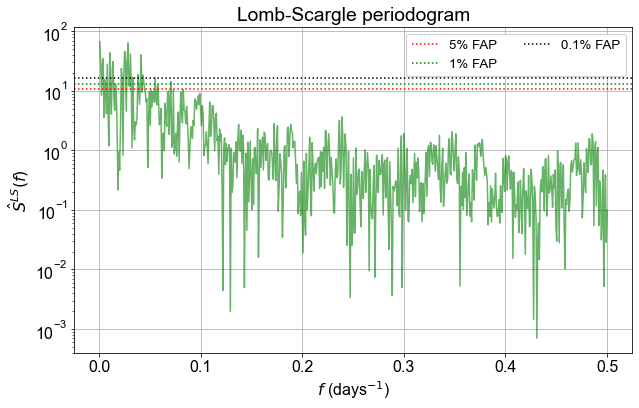

In [5]:
rnf = RedNoiseFALs(time,obs,eobs,0.5)

### Fitting the noise models

The next step in the calculation of red-noise-based false alarm levels is to fit the red noise models to the periodogram. For the sake of comparison, we also a white noise constant power to the periodogram. We fit three spectral functions to the periodogram:

#### 1. Autoregressive model of order 1 - AR(1): 
This is a persistence model, that correlates and observation with its immediate past. Its spectral form is given as,

$ S(f) = \dfrac{\sigma^{2}_{w}}{|1-\phi e^{-2\pi i f}|^{2}}  $

where $\sigma_{w}^{2}$ is the white noise variance, and $\phi$ is the auto-regressive coefficient  which is a measure of the correlation between successive observations; for red noise $0<\phi<1$.

#### 2. Power law:
Power law is motivated by the stellar processes like convective turbulence and magnetic bright point motion,
            
$ S(f) = a f^{-p} $

where $p$ is the exponent and $a$ is the normalization coefficient.

#### 3. White noise:
We fit a constant power $c$ to the periodogram for the white noise model fit,
$ S(f) = c $

We fit the above power spectra to the periodogram by minimizing a negative log-likelihood approximation called the <b>Whittle likelihood</b> which is defined as, 
            $-\mathcal{L}(\theta) \approx \sum\limits_{f}\bigg(\ln[S(f,\theta)]+\dfrac{\hat{S}^{LS}(f)}{S(f,\theta)}\bigg)$

The Whittle likelihood has been widely used for frequency domain analyses in multiple fields for time series that have uniform sampling. This is the first application of Whittle likelihood to the time series with uneven sampling. 

The functions <tt>ar1_fit</tt>, <tt>pl_fit</tt> and <tt>wn_fit</tt>, fit the AR(1), power law and white noise model respectively by minimizing the Whittle likelihood function to get the best fit parameters:

* $\sigma$ and $\phi$ for AR(1)
* $p$ and $a$ for power law
* $c$ for white noise

All three fitting functions, by default, print the values of the best-fit parameters and the minimum Whittle likelihood, however the user can turn it off by setting <tt>display_fitting_result = False</tt>. Similarly, the functions automatically plot the fits on top of the periodogram, the objective function against the number of iterations and the parameter space to check for true convergence, which can be turned off by the user, if necessary by setting <tt>Plot = False</tt> and <tt> Objective_plot = False </tt> respectively. The keyword <tt> plot_limits </tt> specifies the range of the parameter space over which you want to plot your objective function. We perform the minimization using the <tt> scipy.optimize.minimize </tt>. We use <tt> 'Nelder-Mead' </tt> method as default for the optimization, however the users can also choose any other gradient-free method. Similarly, we have specified the tolerence for minimization as <tt> tol=$1 e^{-8}$ </tt> which can also be modified by the user as required. All three fitting functions return the values of the best-fit parameters and the minimum Whittle likelihood.
 
Now let's look at each function separately,

#### 1. AR(1) fit

Syntax: <tt>rnf.ar1_fit(x0, Plot=True, Objective_plot=True, plot_limits=[(0.001,1),(0.5,1.5)], display_fitting_result=True, method="Nelder-Mead", tol=10**-8)</tt>

The initial guess values for the parameters are ordered as $x_{0} = [\phi_{0},\sigma_{0}]$. This function returns:

* <b>$-\mathcal{L}(\theta)_{min}$</b> - The minimum value of the Whittle likelihood 
* <b> $\hat{\phi}$ </b> - Best-fit $\phi$ value
* <b> $\hat{\sigma}$ </b> - Best-fit $\sigma$ value

----------------------- AR(1) FITTING RESULTS -------------------
Optimization terminated successfully.
Phi = 0.77
Sigma = 1.02
Whittle negative log-likelihood = 635.65


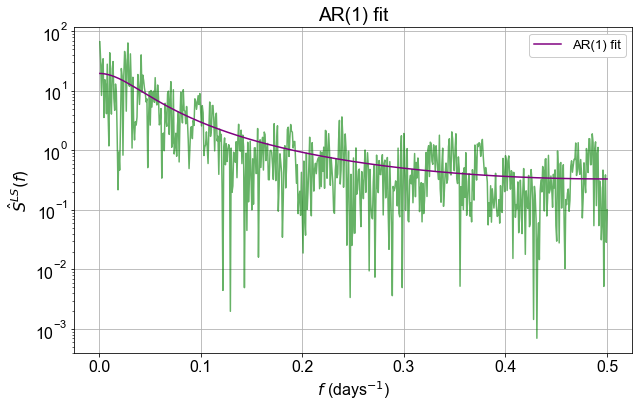

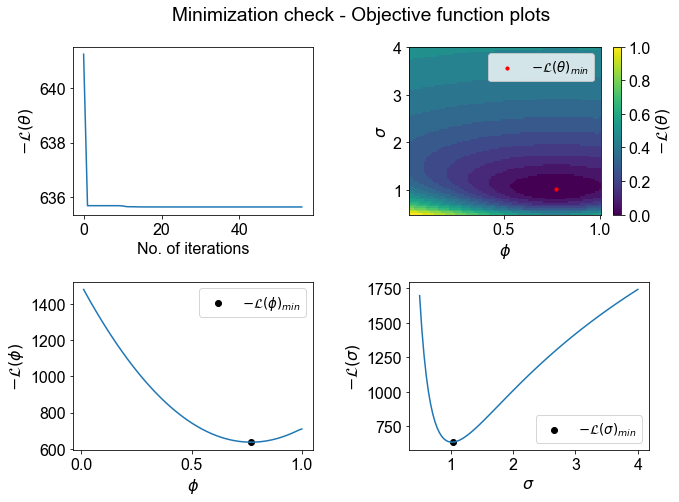

In [6]:
ar = rnf.ar1_fit([0.75,0.9],plot_limits=[(0.01,1),(0.5,4)])

#### 2. Power law fit

Syntax: <tt>pl_fit(fgrid, LS, x0, Plot=True, Objective_plot=True, plot_limits=[(-3,0),(-3,3)], display_fitting_result=True, loglog_plot=True, method="Nelder-Mead", tol=10**-8)</tt>

The initial guess values for the parameters are ordered as $x_{0} = [p,a]$. The power law fit can be better visualized on a loglog plot, which is why this function plots the fit and the LombScargle periodogram on a log-log plot. However, if the user wishes to see the plot on a semilogy axis for comparison with AR(1), they can set <tt>loglog_plot = False</tt>. This function returns:

* <b>$-\mathcal{L}(\theta)_{min}$</b> - The minimum value of the Whittle likelihood 
* <b>$\hat{p}$</b> - Best-fit exponent
* <b>$\hat{a}$</b> - Best-fit normalization coefficient


----------------------- POWER LAW FITTING RESULTS -------------------
Optimization terminated successfully.
Slope = -1.23
Intercept = -0.87
Whittle negative log-likelihood = 656.70


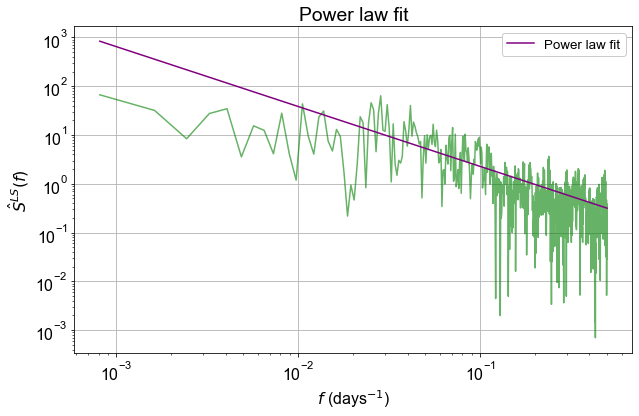

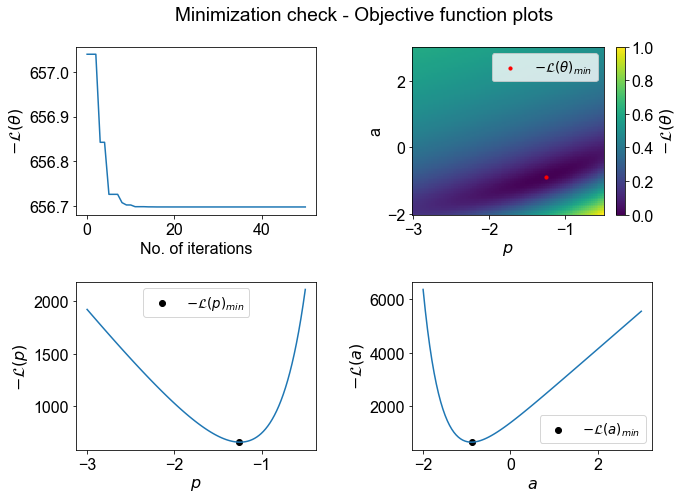

In [7]:
pl = rnf.pl_fit([-1.2,-0.9],plot_limits=[(-3,-0.5),(-2,3)])

#### 3. White noise fit

Syntax: <tt>wn_fit(fgrid, LS, x0, Plot=True, Objective_plot=True, plot_limits=[(0.5,5)], display_fitting_result=True, method="Nelder-Mead", tol=10**-8)</tt>

In this case the initial guess parameter $x_{0}$ is a single value. This function returns:

* <b>$-\mathcal{L}(\theta)_{min}$</b> - The minimum value of the Whittle likelihood 
* <b> $c$ </b> - The best-fit white noise power

----------------------- WHITE NOISE FITTING RESULTS -------------------
Optimization terminated successfully.
Power of white noise = 2.53
Whittle negative log-likelihood = 1186.52


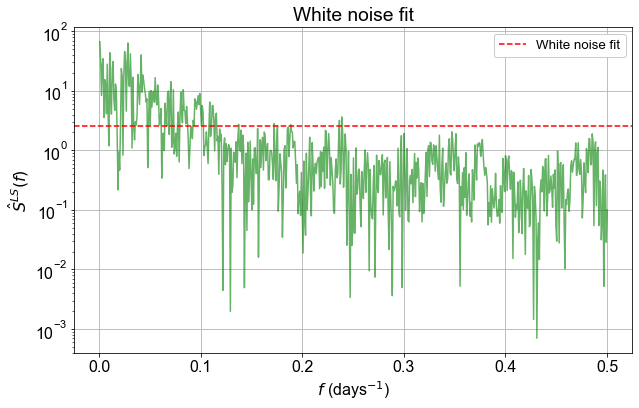

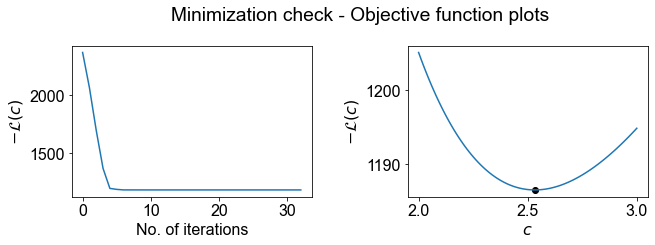

In [8]:
wn = rnf.wn_fit(0.5,plot_limits=[(2,3)])


### Choosing the best model type

To choose the best model type among the three models, we perform Monte Carlo simulations by generating ten thousand new time series by adding independent white noise at each time stamp with mean zero and standard deviation equal to the width of the error bars. We then fit the AR(1), power law, and white noise models to the GLS periodogram of each realization. This experiment creates a distribution of Whittle negative log-likelihood values for each model type, which we plot as histrograms on the same x-axis for comparison and commit to the model with lowest mean Whittle NLL for the particular data set. The function <tt>gen_distributions</tt>:
1. Creates the bootstrap time series using the error bars
2. Computes their GLS periodogram
3. Fits the three models to each bootstrapped realization using the fitting functions defined above
4. Returns and saves the distributions of minimized Whittle NLL values and the best-fit parameters

Syntax: <tt>gen_distributions(time,obs,eobs,fgrid,save_file,n_bootstrap=10000,x0_pl=[-0.5,-0.9],x0_ar1=[0.7,0.5],x0_wn=[0.1],histograms=True,detrending=True)</tt>

This function takes the time, observations and errorbars of the original time series as input, it also requires the user to give the frequency grid on which the periodogram has to be compueted and the path to a file in which the Whittle NLL and the best-fit parameter values can be saved. The default number of bootstraps is 10000, however it can be varied using the <tt>n_bootstrap</tt> keyword. By default, our software detrend the data before computing the periodogram which can be turned off by setting <tt>detrending = False</tt>. The <tt>gen_distribution</tt> function automatically plots the histograms of the Whittle NLL distributions but you can turn it off by setting <tt>histograms = False</tt>. To perform the optimization, this function requires some initial guess values for the parameters which can be approximated from the best-fit parameter values of the original data. The keywords <tt>x0_ar1</tt>, <tt>x0_pl</tt>, and <tt>x0_wn</tt> let you enter the initial guess parameters for the AR(1), power law and white noise models respectively. The <tt>'gen_distribution'</tt>
function returns the distributions in the following order:

1. Whittle NLL distribution for power law fits
2. Whittle NLL distribution for AR(1) fits
3. Whittle NLL distribution for white noise fits
4. Distribution of exponents '$p$' for power law fits
5. Distribution of normalization constants '$a$' for power law fits
6. Distribution of autoregressive coefficient $\phi$ for the AR(1) fits
7. Distribution of $\sigma$ for the AR(1) fits

We need the distributions of the best-fit parameters for the calculation of FALs in order to account for the uncertainties in the parameter estimation.

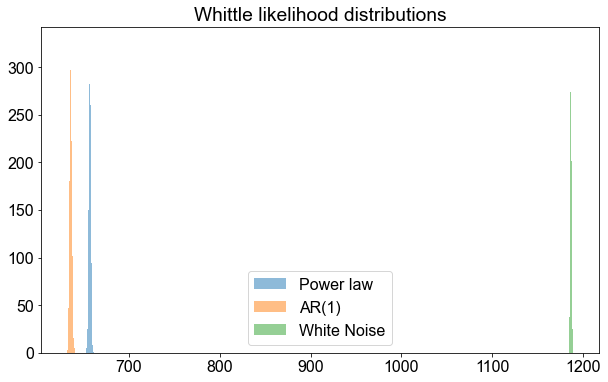

In [9]:

dist = rnf.gen_distributions(n_bootstrap=10000,save_file="Demo_aCenB.txt")



You can see in the above histogram plot that the distributions of the two red noise models lie way below the WNLL distribution of the white noise model. Remember, we're looking at the distributions of a negative log-likelihood which implies that the best-fit model has the lowest WNLL values. In this case, we can see that AR(1) is the best-fit model. Therefore, we go ahead and calculate the false alarm levels (FALs) based on the AR(1) model. 

### Calculating the FALs

We calculate the FALs from time-domain realizations of the best-fit noise model which is AR(1) in this case, the function <tt>fal_ar1</tt> chooses the initial observation value $x_0(t_0)$ from a standard normal distribution, and then use the following equation recursively to obtain $x_n(t_n)$,

$x_{n} = \phi^{(t_{n}-t_{n-1}) / 1}\; x_{n-1} + \zeta_{n}$

where $\zeta_{n}$ is white noise with variance $\sigma^{2}$. The parameters $\phi$ and $\sigma$ are chosen from the distribution of the parameters generated in the previous step to account for the uncertainties in the parameter estimation. The priodogram is computed for all bootstrapped realizations and the power distribution is saved at each frequency. The 95\%, 99\%, and 99.9\% percentile at each frequency is then to define the 5\%, 1\%, and 0.1\% false alarm levels.

Syntax: <tt>fal_ar1(time,obs,fgrid,phi,sigma,n_bootstraps=10000,detrending=True,Plot=True,title="FALs based on AR(1)")</tt>

The function <tt>fal_ar1</tt> requires the original time series, frequency grid, the model parameter ($\phi$,$\sigma$) distributions as input. The default number of boostrap time series is set to $10000$ as it is the minimum number of LSPs required for an accurate false alarm level of $0.1\%$. The option <tt>detrending</tt> is set to <tt>True</tt>, but can be turned off. You have to be consistent with whether you choose to detrend the data or not throughout the calculation. The function automatically plots the LombScargle periodogram along with the AR(1)-based FALs, if you do not wish to see the plot you can set <tt>Plot=False</tt>. The title of the plot can be created by using the keyword <tt>'title'</tt>. The function outputs the 95\%, 99\%, 99.9\% and 50\% percentiles as an array with shape <tt>(fgrid,4)</tt>.

In [10]:
save_file = 'Demo_aCenB.txt'
dist = pd.read_csv(save_file,delim_whitespace=True)
phi = dist["Phi"]
sigma = dist["Sigma"]


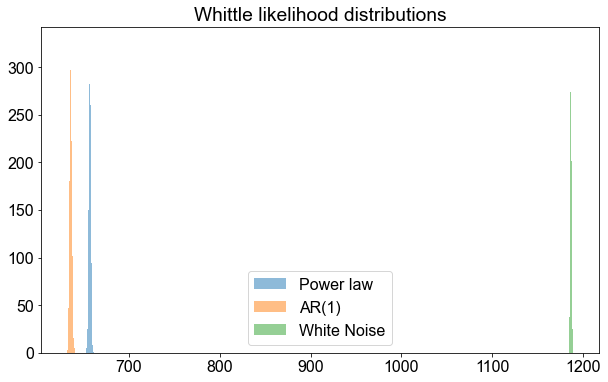

In [11]:
bins = 100
plt.figure(figsize=(10,6))
plt.title("Whittle likelihood distributions")
plt.hist(dist["WNLL_PL"],label="Power law",alpha =0.5,bins=bins)
plt.hist(dist["WNLL_AR1"],label="AR(1)",alpha =0.5,bins=bins)
plt.hist(dist["WNLL_WN"],label="White Noise",alpha =0.5,bins=bins)
plt.legend()

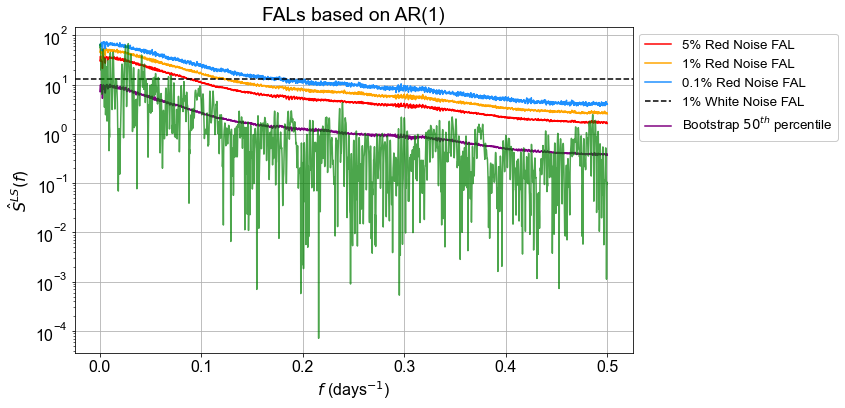

In [12]:
# We get the distribution of parameters to calculate the FALs

fals_ar1 = rnf.fal_ar1(phi,sigma)

The true rotation signal is significant at 0.1% red noise false alarm level.